In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Set Up

In [2]:
df_18 = pd.read_csv('df_18_cluster.csv')
df_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 82 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pop                     1909 non-null   float64
 1   hh                      1909 non-null   float64
 2   state                   1909 non-null   int64  
 3   county                  1909 non-null   int64  
 4   tract                   1909 non-null   int64  
 5   FIPS                    1909 non-null   int64  
 6   year                    1909 non-null   int64  
 7   rail                    1909 non-null   float64
 8   total_li                1909 non-null   float64
 9   pctch_real_mhval_sl     1909 non-null   float64
 10  per_ch_rent_sl          1909 non-null   float64
 11  lostli                  1909 non-null   float64
 12  more_ind_inc            1909 non-null   int64  
 13  pctch_ind_inc           1909 non-null   float64
 14  log_medhinc             1909 non-null   

We want to create a dataset specific to training the ML models. For this task, we only use "external" features - those that are not related to inflow migration. We have used these variables to detect patterns before, and now we are interested in learning about using other features to predict our migration type, indicated by the "cluster" variable. 

In [3]:
to_rm_mov = [col for col in df_18.columns if 'mov' in col]
df_18_c = df_18.drop(to_rm_mov, axis=1)
df_18_c = df_18_c.drop(['year', 'state', 'county', 'tract', 'year', 'FIPS', 'lostli', 'total_li'], axis=1)
df_18_c.columns

Index(['pop', 'hh', 'rail', 'pctch_real_mhval_sl', 'per_ch_rent_sl',
       'more_ind_inc', 'pctch_ind_inc', 'log_medhinc', 'log_mhval',
       'log_mrent', 'log_iinc', 'price_rent_ratio', 'white_prop', 'ohu_prop',
       'rhu_prop', 'pro_old_build', 'prop_lostli', 'prop_hhinc_10000',
       'prop_hhinc_15000', 'prop_hhinc_20000', 'prop_hhinc_25000',
       'prop_hhinc_30000', 'prop_hhinc_35000', 'prop_hhinc_40000',
       'prop_hhinc_45000', 'prop_hhinc_50000', 'prop_hhinc_60000',
       'prop_hhinc_75000', 'prop_hhinc_100000', 'prop_hhinc_125000',
       'prop_hhinc_150000', 'prop_hhinc_200000', 'prop_hhinc_201000',
       'prop_bd', 'prop_grad', 'cluster'],
      dtype='object')

Normalize only variables that are not in terms of proportion, and those that are not categorical variables. 

In [12]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
df_18_c['pop'] = std.fit_transform(df_18_c[['pop']])
df_18_c['pop'] = df_18_c['pop'].astype(float)
df_18_c['hh'] = std.fit_transform(df_18_c[['hh']])
df_18_c['hh'] = df_18_c['hh'].astype(float)
df_18_c

,pop,hh,rail,pctch_real_mhval_sl,per_ch_rent_sl,more_ind_inc,pctch_ind_inc,log_medhinc,log_mhval,log_mrent,...,prop_hhinc_60000,prop_hhinc_75000,prop_hhinc_100000,prop_hhinc_125000,prop_hhinc_150000,prop_hhinc_200000,prop_hhinc_201000,prop_bd,prop_grad,cluster
0,-0.908316,-0.866872,0.0,0.010385,0.302281,0,-0.093011,10.811040,11.731257,6.876265,...,0.050808,0.117783,0.132794,0.092379,0.049654,0.026559,0.025404,0.041809,0.029863,3
1,-0.255768,-0.482249,0.0,0.127786,0.139824,1,0.305803,10.740194,11.723186,6.926577,...,0.138631,0.090448,0.065934,0.058326,0.049873,0.051564,0.005072,0.044693,0.025805,0
2,-0.270986,-0.584168,0.0,0.090727,0.233463,1,0.051462,11.292653,11.979172,7.475339,...,0.035487,0.123749,0.272066,0.140127,0.069154,0.043676,0.015469,0.117821,0.035695,0
3,0.635663,1.029551,0.0,-0.173610,0.092780,1,0.104372,11.176669,12.034097,6.749931,...,0.114039,0.224784,0.092631,0.092631,0.107452,0.108687,0.039111,0.123507,0.067639,1
4,-0.718316,-0.171638,0.0,-0.005649,-0.048889,1,0.139956,10.626024,11.688558,6.853299,...,0.079917,0.123697,0.083391,0.011814,0.065323,0.013204,0.004864,0.099057,0.048258,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,-0.170914,-0.636341,0.0,0.097179,0.139824,1,0.158390,10.301357,11.989160,6.655440,...,0.091856,0.081439,0.021780,0.105114,0.011364,0.030303,0.000000,0.037281,0.011920,0
1905,0.033843,-0.596301,0.0,-0.066508,0.139824,1,0.065778,10.586938,11.949889,6.687109,...,0.089991,0.067034,0.100092,0.063361,0.008264,0.015611,0.008264,0.024618,0.005015,0
1906,-0.317564,-0.641194,1.0,0.077217,0.139824,1,0.301792,10.446596,11.839347,6.793466,...,0.074144,0.074144,0.079848,0.038023,0.084601,0.000000,0.000000,0.041103,0.013517,3
1907,-0.371059,-0.866872,1.0,-0.082327,0.139824,1,0.172925,10.489189,11.923046,6.641182,...,0.101617,0.056582,0.114319,0.039261,0.013857,0.012702,0.000000,0.049302,0.007125,0


In [13]:
X = df_18_c.drop(columns=['cluster'], axis=1)
y = df_18_c['cluster']
X.shape, y.shape

((1909, 35), (1909,))

# Handling Class Inbalance

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1336, 35), (573, 35), (1336,), (573,))

Let's first run a baseline Random Forest model to check performance. 

In [15]:
rf_base = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_base.fit(X_train, y_train)
y_pred = rf_base.predict(X_test)
accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'Baseline model accuracy: {accuracy_score(y_test, y_pred)}')


[[122   0   0  52   5]
 [ 14   1   0  27   5]
 [  0   0  36   1  21]
 [ 53   0   1  92  28]
 [  5   0  10  44  56]]
Baseline model accuracy: 0.5357766143106457


We got a baseline of 0.53, which is moderate. The following code implements a few ways to improve the model. 

In [16]:
y_train.value_counts()


cluster
0    432
3    428
4    260
2    109
1    107
Name: count, dtype: int64

There are some class imbalance. First, we try over-sampling.

Original class distribution:
[(0, 432), (1, 107), (2, 109), (3, 428), (4, 260)]

Class distribution after SMOTE:
[(0, 432), (1, 432), (2, 432), (3, 432), (4, 432)]

Results:
Balanced Accuracy: 0.5565

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       179
           1       0.32      0.49      0.39        47
           2       0.73      0.78      0.75        58
           3       0.44      0.34      0.39       174
           4       0.49      0.51      0.50       115

    accuracy                           0.53       573
   macro avg       0.52      0.56      0.54       573
weighted avg       0.53      0.53      0.53       573



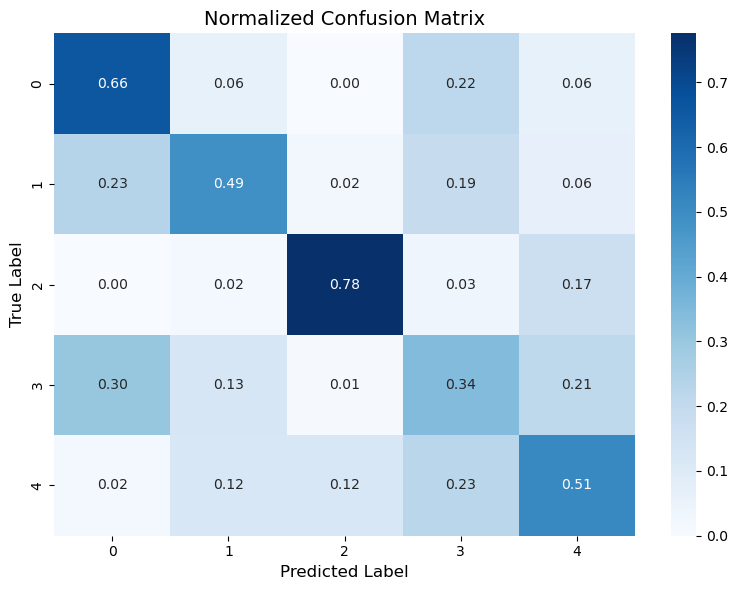

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from collections import Counter

# check class distribution before sampling
print("Original class distribution:")
print(sorted(Counter(y_train).items()))

# apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# check class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(sorted(Counter(y_train_smote).items()))


def train_and_plt(X_train, y_train):

    # train the model with SMOTE-resampled data
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    # make predictions
    y_pred = rf.predict(X_test)

    # evaluate the model
    print("\nResults:")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # create heatmap with annotations
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))

    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

train_and_plt(X_train_smote, y_train_smote)

Original class distribution:
[(0, 432), (1, 107), (2, 109), (3, 428), (4, 260)]

Class distribution after Borderline SMOTE:
[(0, 432), (1, 432), (2, 432), (3, 432), (4, 432)]

Results:
Balanced Accuracy: 0.5384

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       179
           1       0.26      0.36      0.30        47
           2       0.71      0.72      0.72        58
           3       0.49      0.42      0.45       174
           4       0.52      0.52      0.52       115

    accuracy                           0.54       573
   macro avg       0.53      0.54      0.53       573
weighted avg       0.55      0.54      0.54       573



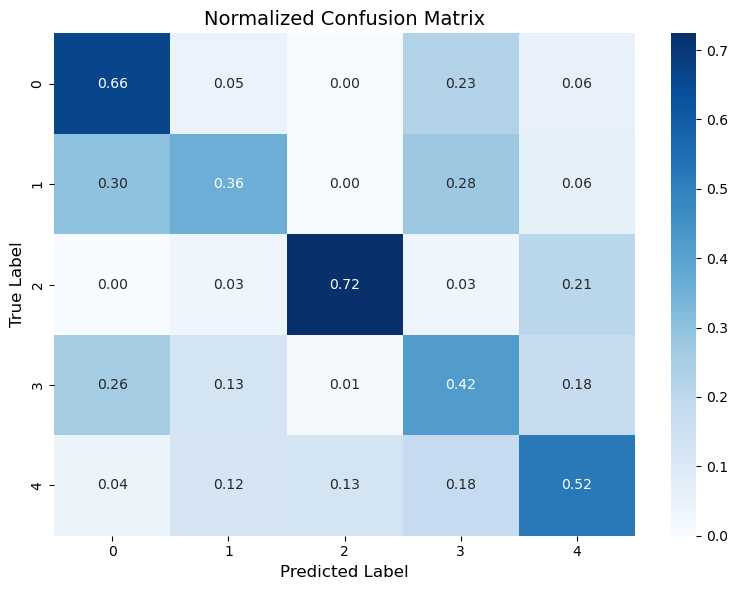

In [18]:
# Borderline SMOTE Version
from imblearn.over_sampling import BorderlineSMOTE

# Check original class distribution
print("Original class distribution:")
print(sorted(Counter(y_train).items()))

# Apply Borderline SMOTE with reduced neighbors
b_smote = BorderlineSMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = b_smote.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("\nClass distribution after Borderline SMOTE:")
print(sorted(Counter(y_train_resampled).items()))

train_and_plt(X_train_resampled, y_train_resampled)

Original class distribution:
[(0, 432), (1, 107), (2, 109), (3, 428), (4, 260)]

Class distribution after SVM SMOTE:
[(0, 432), (1, 286), (2, 432), (3, 432), (4, 432)]

Results:
Balanced Accuracy: 0.5674

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       179
           1       0.46      0.40      0.43        47
           2       0.73      0.78      0.75        58
           3       0.47      0.47      0.47       174
           4       0.54      0.50      0.52       115

    accuracy                           0.57       573
   macro avg       0.57      0.57      0.57       573
weighted avg       0.56      0.57      0.57       573



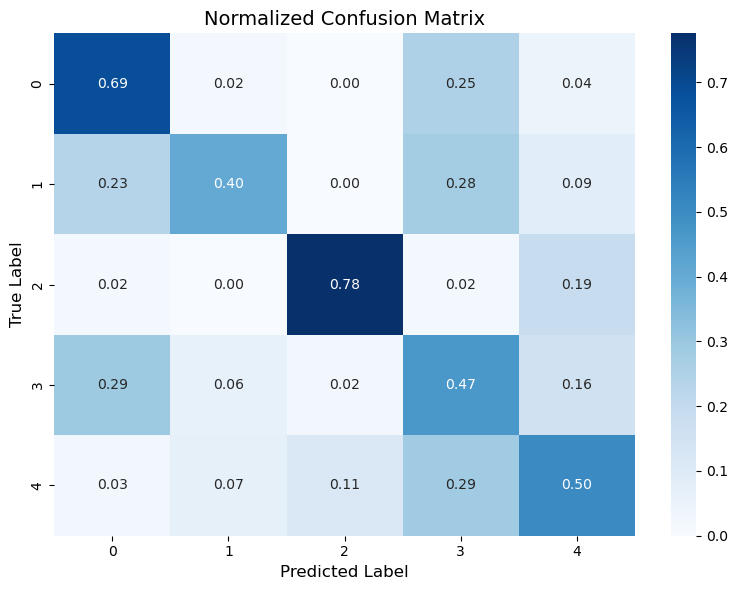

In [19]:
from imblearn.over_sampling import SVMSMOTE

# Check original distribution
print("Original class distribution:")
print(sorted(Counter(y_train).items()))

# Apply SVM SMOTE
svm_smote = SVMSMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train, y_train)

print("\nClass distribution after SVM SMOTE:")
print(sorted(Counter(y_train_resampled).items()))

train_and_plt(X_train_resampled, y_train_resampled)

Then, we try undersampling.

Original class distribution:
[(0, 432), (1, 107), (2, 109), (3, 428), (4, 260)]

Class distribution after Random Undersampling:
[(0, 107), (1, 107), (2, 107), (3, 107), (4, 107)]

Results:
Balanced Accuracy: 0.5708

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       179
           1       0.27      0.62      0.38        47
           2       0.67      0.81      0.73        58
           3       0.49      0.31      0.38       174
           4       0.46      0.51      0.48       115

    accuracy                           0.52       573
   macro avg       0.52      0.57      0.52       573
weighted avg       0.54      0.52      0.52       573



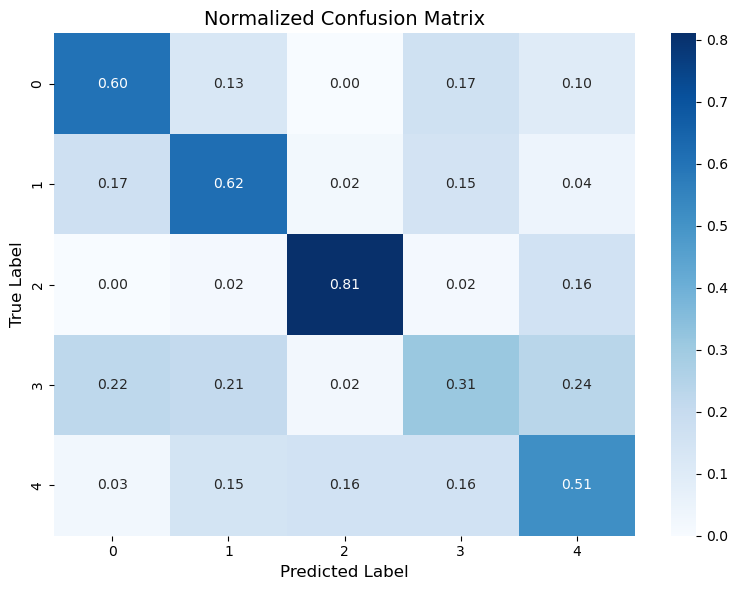

In [20]:
from imblearn.under_sampling import RandomUnderSampler

# Check original distribution
print("Original class distribution:")
print(sorted(Counter(y_train).items()))

# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("\nClass distribution after Random Undersampling:")
print(sorted(Counter(y_train_resampled).items()))

train_and_plt(X_train_resampled, y_train_resampled)

SVMSMOTE performs the best. Using RF as a test, it has:
- Highest accuracy (0.57)
- Best F1-scores for almost every class
- More consistent precision and recall values
- Best macro and weighted averages:

We use it as our resampling method.

# Model Training

In [21]:
svm_smote = SVMSMOTE(random_state=42, k_neighbors=2)
X_train_rs, y_train_rs = svm_smote.fit_resample(X_train, y_train)
X_train_rs.shape, y_train_rs.shape

((2014, 35), (2014,))

## Random Forest

Accuracy: 0.5689

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       179
           1       0.46      0.40      0.43        47
           2       0.73      0.78      0.75        58
           3       0.47      0.47      0.47       174
           4       0.54      0.50      0.52       115

    accuracy                           0.57       573
   macro avg       0.57      0.57      0.57       573
weighted avg       0.56      0.57      0.57       573



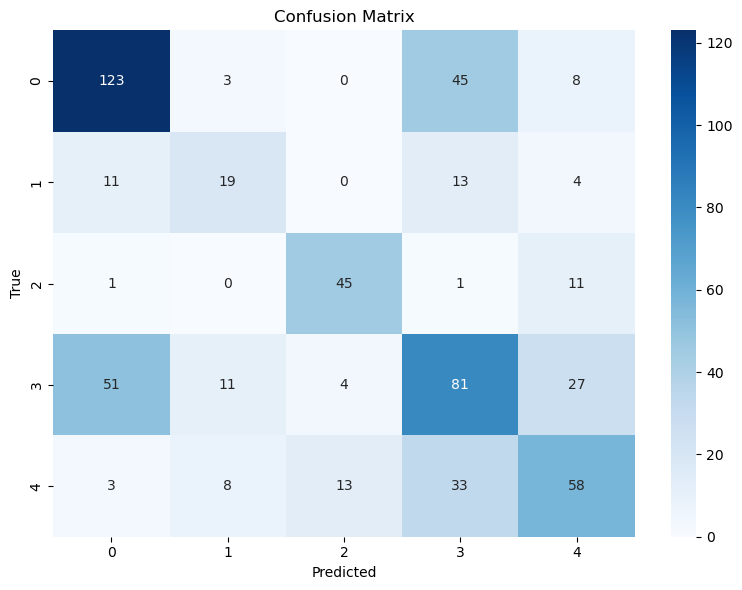

In [22]:
# Train Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,    
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X_train_rs, y_train_rs)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)  


def plot_cm(y_test, y_pred):
    # Evaluate the model
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=rf_model.classes_,
                yticklabels=rf_model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_cm(y_test, y_pred_rf)


Fine-tuning hyperparameters. 

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter space for random search
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  
    cv=5,       # 5-fold cross-validation
    scoring='balanced_accuracy',
    n_jobs=-1,  
    verbose=1,
    random_state=42
)

random_search.fit(X_train_rs, y_train_rs)
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

best_rf = random_search.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters found:
n_estimators: 300
min_samples_split: 5
min_samples_leaf: 4
max_features: log2
max_depth: None
class_weight: balanced


Accuracy: 0.5480

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       179
           1       0.33      0.43      0.37        47
           2       0.69      0.72      0.71        58
           3       0.46      0.44      0.45       174
           4       0.51      0.50      0.51       115

    accuracy                           0.55       573
   macro avg       0.53      0.55      0.54       573
weighted avg       0.55      0.55      0.55       573



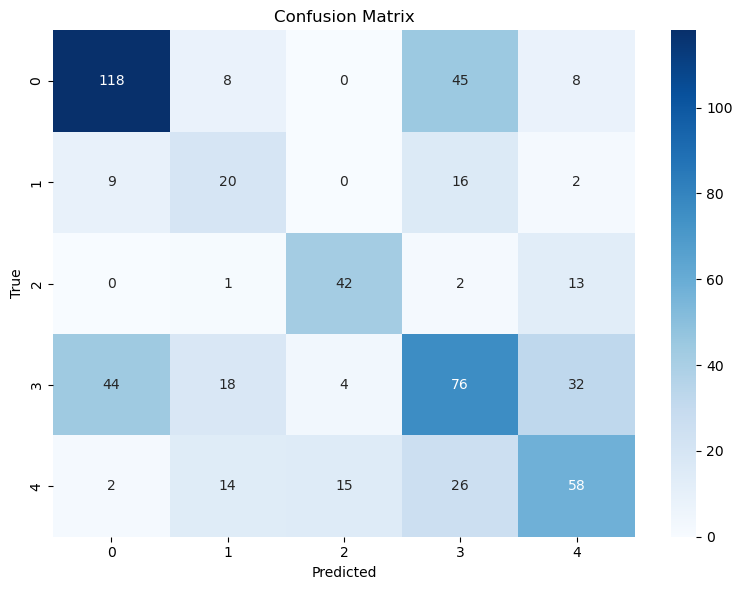

In [24]:
plot_cm(y_test, y_pred_rf_best)

## XGBoost

Accuracy: 0.5218

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       179
           1       0.41      0.38      0.40        47
           2       0.72      0.71      0.71        58
           3       0.40      0.41      0.41       174
           4       0.51      0.48      0.49       115

    accuracy                           0.52       573
   macro avg       0.53      0.52      0.53       573
weighted avg       0.52      0.52      0.52       573



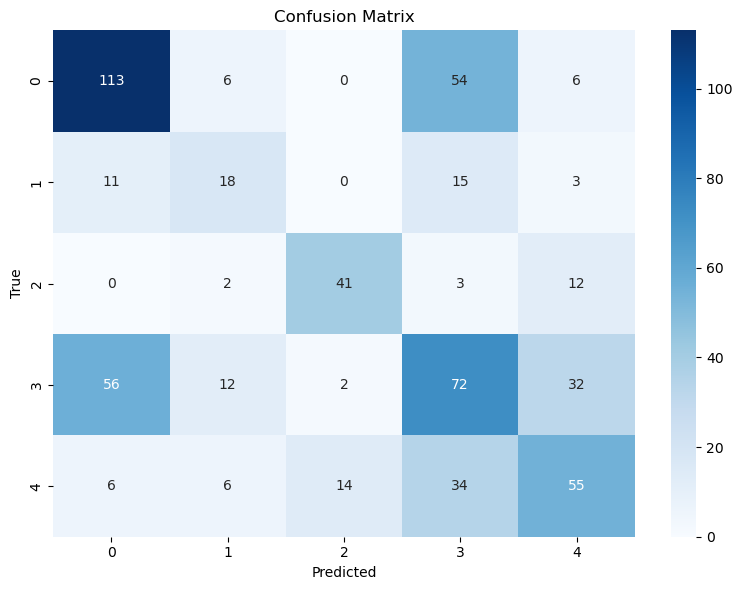

In [25]:
from xgboost import XGBClassifier

# Build and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    num_class=5,  # For your 5 categories
    eval_metric='mlogloss'
)

xgb_model.fit(X_train_rs, y_train_rs)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

plot_cm(y_test, y_pred_xgb)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/macs30100/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:12:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "class_weight", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/macs30100/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:12:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "class_weight", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/macs30100/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:12:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "class_weight", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/macs3010

Accuracy: 0.5236

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       179
           1       0.36      0.38      0.37        47
           2       0.72      0.76      0.74        58
           3       0.42      0.43      0.42       174
           4       0.52      0.45      0.48       115

    accuracy                           0.52       573
   macro avg       0.52      0.53      0.53       573
weighted avg       0.52      0.52      0.52       573



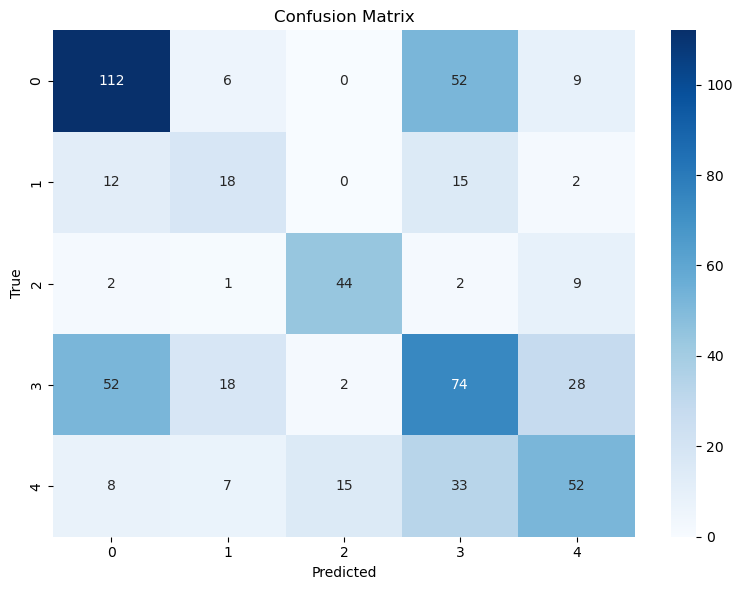

In [26]:
# Now train XGBoost with RandomizedSearchCV on reduced feature set
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', num_class=5, eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_rs, y_train_rs)

# Get the best parameters and create final model
best_params = random_search.best_params_
best_xgb_model = XGBClassifier(objective='multi:softprob', num_class=5, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train_rs, y_train_rs)

# Make predictions
y_pred_xgb_best = best_xgb_model.predict(X_test)
y_prob_xgb_best = best_xgb_model.predict_proba(X_test)
plot_cm(y_test, y_pred_xgb_best)


## Ensemble Models

In this section, I experiment with a few ensemble models. 

Accuracy: 0.5497

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.70      0.67       179
           1       0.47      0.36      0.41        47
           2       0.74      0.67      0.70        58
           3       0.44      0.43      0.43       174
           4       0.50      0.51      0.51       115

    accuracy                           0.55       573
   macro avg       0.56      0.54      0.54       573
weighted avg       0.55      0.55      0.55       573



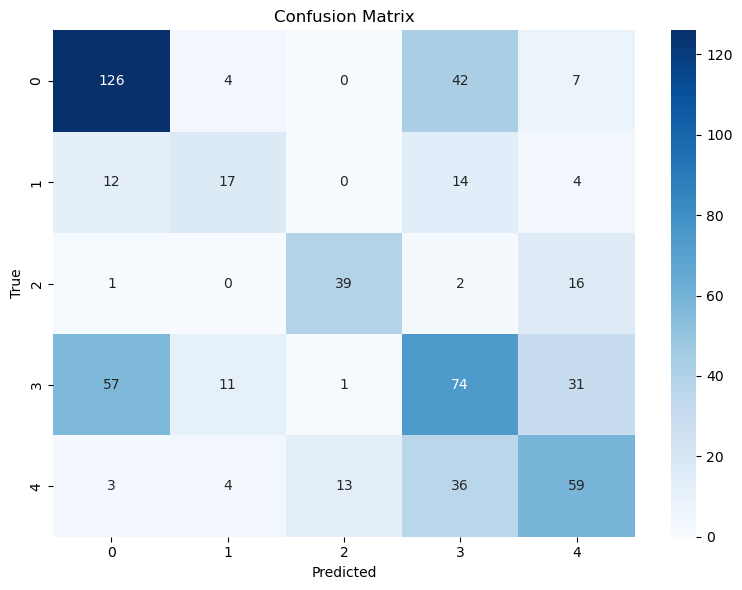

In [27]:
from sklearn.ensemble import StackingClassifier
# Stacking Ensemble
base_estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]

# Define the meta-classifier (final estimator)
meta_classifier = LogisticRegression()

# Create the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_classifier,
    cv=5  # Optional: cross-validation for generating meta features
)

stacking_clf.fit(X_train_rs, y_train_rs)
stacking_pred = stacking_clf.predict(X_test)

plot_cm(y_test, stacking_pred)

Fitting the voting classifier...
Making predictions with individual models and voting ensemble...
Accuracy: 0.5462

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65       179
           1       0.45      0.38      0.41        47
           2       0.71      0.71      0.71        58
           3       0.44      0.44      0.44       174
           4       0.52      0.50      0.51       115

    accuracy                           0.55       573
   macro avg       0.55      0.54      0.54       573
weighted avg       0.54      0.55      0.54       573



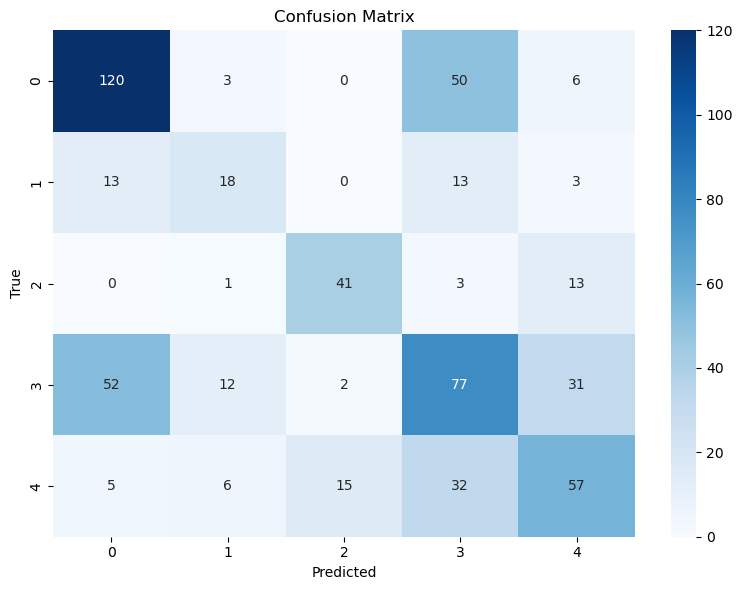

In [28]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_model),        
        ('xgb', xgb_model)   
    ],
    voting='soft'             
)

print("Fitting the voting classifier...")
voting_classifier.fit(X_train_rs, y_train_rs)

print("Making predictions with individual models and voting ensemble...")
voting_pred = voting_classifier.predict(X_test)
plot_cm(y_test, voting_pred)


In [29]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score
# Model Comparison
print("\n--- Model Comparison ---\n")

def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return accuracy, balanced_accuracy, f1, recall

# Get metrics for all models
rf_metrics = get_metrics(y_test, y_pred_rf)
rf_best_metrics = get_metrics(y_test, y_pred_rf_best)
xgb_metrics = get_metrics(y_test, y_pred_xgb)
xgb_best_metrics = get_metrics(y_test, y_pred_xgb_best)
stacking_metrics = get_metrics(y_test, stacking_pred)
voting_metrics = get_metrics(y_test, voting_pred)

# Print comparison table
print("Model Performance Comparison:")
print("{:<20} {:<15} {:<20} {:<15} {:<15}".format("Model", "Accuracy", "Balanced Accuracy", "F1 Score", "Recall"))
print("{:<20} {:<15.4f} {:<20.4f} {:<15.4f} {:<15.4f}".format("Random Forest", rf_metrics[0], rf_metrics[1], rf_metrics[2], rf_metrics[3]))
print("{:<20} {:<15.4f} {:<20.4f} {:<15.4f} {:<15.4f}".format("Random Forest RS", rf_best_metrics[0], rf_best_metrics[1], rf_best_metrics[2], rf_best_metrics[3]))
print("{:<20} {:<15.4f} {:<20.4f} {:<15.4f} {:<15.4f}".format("XGBoost", xgb_metrics[0], xgb_metrics[1], xgb_metrics[2], xgb_metrics[3]))
print("{:<20} {:<15.4f} {:<20.4f} {:<15.4f} {:<15.4f}".format("XGBoost RS", xgb_best_metrics[0], xgb_best_metrics[1], xgb_best_metrics[2], xgb_best_metrics[3]))
print("{:<20} {:<15.4f} {:<20.4f} {:<15.4f} {:<15.4f}".format("Stacking", stacking_metrics[0], stacking_metrics[1], stacking_metrics[2], stacking_metrics[3]))
print("{:<20} {:<15.4f} {:<20.4f} {:<15.4f} {:<15.4f}".format("Voting", voting_metrics[0], voting_metrics[1], voting_metrics[2], voting_metrics[3]))


--- Model Comparison ---

Model Performance Comparison:
Model                Accuracy        Balanced Accuracy    F1 Score        Recall         
Random Forest        0.5689          0.5674               0.5663          0.5689         
Random Forest RS     0.5480          0.5500               0.5495          0.5480         
XGBoost              0.5218          0.5226               0.5213          0.5218         
XGBoost RS           0.5236          0.5290               0.5225          0.5236         
Stacking             0.5497          0.5353               0.5465          0.5497         
Voting               0.5462          0.5397               0.5444          0.5462         


Our raw RF model has the best performance. We will use it to generate labels for data from 2023. 

In [40]:
importances = rf_model.feature_importances_
feature_names = X.columns  

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)

,Feature,Importance
33,prop_bd,0.069257
14,rhu_prop,0.064639
13,ohu_prop,0.056298
34,prop_grad,0.051941
15,pro_old_build,0.036682
10,log_iinc,0.034083
12,white_prop,0.031216
11,price_rent_ratio,0.030828
8,log_mhval,0.029860
31,prop_hhinc_200000,0.029638


# Labeling

In [31]:
df = pd.read_csv('training_data_features.csv')
df_23 = df[df['year'] == 2023]
df_23.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1906 entries, 0 to 1905
Data columns (total 83 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pop                     1906 non-null   float64
 1   hh                      1906 non-null   float64
 2   state                   1906 non-null   int64  
 3   county                  1906 non-null   int64  
 4   tract                   1906 non-null   int64  
 5   FIPS                    1906 non-null   int64  
 6   typology                0 non-null      float64
 7   year                    1906 non-null   int64  
 8   typ_cat                 0 non-null      object 
 9   rail                    1906 non-null   float64
 10  total_li                1906 non-null   float64
 11  pctch_real_mhval_sl     1906 non-null   float64
 12  per_ch_rent_sl          1906 non-null   float64
 13  lostli                  1906 non-null   float64
 14  more_ind_inc            1906 non-null   int64

In [32]:
cols_to_keep = df_18_c.columns.to_list()
cols_to_keep.remove('cluster')
df_23_c = df_23[cols_to_keep]

# Check the shape of the dataframes
df_18_c.shape, df_23_c.shape

((1909, 36), (1906, 35))

In [33]:
std = StandardScaler()
df_23_c['pop'] = std.fit_transform(df_23_c[['pop']])
df_23_c['pop'] = df_23_c['pop'].astype(float)
df_23_c['hh'] = std.fit_transform(df_23_c[['hh']])
df_23_c['hh'] = df_23_c['hh'].astype(float)
df_23_c

/var/folders/11/qx8t9mx577s1vr7n1wmm37th0000gn/T/ipykernel_11844/3458241563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_23_c['pop'] = std.fit_transform(df_23_c[['pop']])
/var/folders/11/qx8t9mx577s1vr7n1wmm37th0000gn/T/ipykernel_11844/3458241563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_23_c['pop'] = df_23_c['pop'].astype(float)
/var/folders/11/qx8t9mx577s1vr7n1wmm37th0000gn/T/ipykernel_11844/3458241563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,pop,hh,rail,pctch_real_mhval_sl,per_ch_rent_sl,more_ind_inc,pctch_ind_inc,log_medhinc,log_mhval,log_mrent,...,prop_hhinc_50000,prop_hhinc_60000,prop_hhinc_75000,prop_hhinc_100000,prop_hhinc_125000,prop_hhinc_150000,prop_hhinc_200000,prop_hhinc_201000,prop_bd,prop_grad
0,-0.242487,0.799776,0.0,-0.047692,0.183880,1,0.118908,10.957886,12.409519,6.941877,...,0.043836,0.046575,0.136530,0.190868,0.037443,0.053881,0.056621,0.056164,0.207998,0.153247
1,2.041151,1.966543,0.0,0.262641,0.076885,1,0.210674,10.621912,12.194017,7.004567,...,0.076695,0.016129,0.063199,0.189598,0.072416,0.066162,0.052995,0.035221,0.090142,0.117027
2,-0.902980,-0.658683,1.0,0.199330,0.097398,1,0.257321,10.726629,12.163441,6.973326,...,0.091150,0.092035,0.031858,0.208850,0.087611,0.027434,0.058407,0.040708,0.251437,0.124952
3,1.286049,2.168801,1.0,0.450323,0.064388,1,0.062125,10.904833,12.437447,6.945863,...,0.025432,0.091994,0.132496,0.136892,0.075981,0.076923,0.052119,0.071900,0.251149,0.144826
4,0.086281,0.618157,0.0,-0.132326,0.021193,1,0.378890,10.609302,12.152602,6.938677,...,0.130224,0.049077,0.087464,0.105928,0.048105,0.062682,0.041302,0.067055,0.233302,0.139654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,-0.033164,-0.072548,0.0,0.115286,-0.050191,0,-0.068167,11.308145,12.084512,6.813354,...,0.026992,0.048201,0.046915,0.107326,0.172879,0.095758,0.146530,0.073265,0.110539,0.026225
1902,-0.786492,-0.442666,0.0,0.031826,-0.003126,1,0.135010,11.078589,11.955702,6.868997,...,0.020979,0.066045,0.078477,0.200466,0.125874,0.050505,0.083139,0.088578,0.057377,0.042053
1903,-1.358880,-1.159512,0.0,0.154166,-0.053472,1,0.132123,11.047421,12.138112,7.009805,...,0.027415,0.116188,0.103133,0.143603,0.087467,0.126632,0.104439,0.060052,0.051687,0.031556
1904,0.031289,0.190250,0.0,0.149799,0.368435,1,0.492664,11.215555,12.256829,7.401241,...,0.014883,0.108185,0.115054,0.129365,0.076703,0.184888,0.089868,0.072696,0.112915,0.071616


In [34]:
X_23 = df_23_c
y_23_pred = rf_model.predict(X_23)
df_23['cluster'] = y_23_pred

/var/folders/11/qx8t9mx577s1vr7n1wmm37th0000gn/T/ipykernel_11844/2023094255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_23['cluster'] = y_23_pred


In [35]:
df_23.head()

,pop,hh,state,county,tract,FIPS,typology,year,typ_cat,rail,...,prop_hhinc_60000,prop_hhinc_75000,prop_hhinc_100000,prop_hhinc_125000,prop_hhinc_150000,prop_hhinc_200000,prop_hhinc_201000,prop_bd,prop_grad,cluster
0,3726.0,2190.0,17,31,10100,17031010100,NaN,2023,NaN,0.0,...,0.046575,0.136530,0.190868,0.037443,0.053881,0.056621,0.056164,0.207998,0.153247,4
1,7588.0,3038.0,17,31,10201,17031010201,NaN,2023,NaN,0.0,...,0.016129,0.063199,0.189598,0.072416,0.066162,0.052995,0.035221,0.090142,0.117027,4
2,2609.0,1130.0,17,31,10202,17031010202,NaN,2023,NaN,1.0,...,0.092035,0.031858,0.208850,0.087611,0.027434,0.058407,0.040708,0.251437,0.124952,2
3,6311.0,3185.0,17,31,10300,17031010300,NaN,2023,NaN,1.0,...,0.091994,0.132496,0.136892,0.075981,0.076923,0.052119,0.071900,0.251149,0.144826,4
4,4282.0,2058.0,17,31,10400,17031010400,NaN,2023,NaN,0.0,...,0.049077,0.087464,0.105928,0.048105,0.062682,0.041302,0.067055,0.233302,0.139654,4


In [36]:
df_final = pd.concat([df_18, df_23], ignore_index=True)
df_final['cluster'] = df_final['cluster'].astype(int)

In [37]:
df_final.head()

,pop,hh,state,county,tract,FIPS,typology,year,typ_cat,rail,...,prop_hhinc_60000,prop_hhinc_75000,prop_hhinc_100000,prop_hhinc_125000,prop_hhinc_150000,prop_hhinc_200000,prop_hhinc_201000,prop_bd,prop_grad,cluster
0,2344.0,866.0,17,197,882900,17197882900,3.0,2018,['ARG'],0.0,...,0.050808,0.117783,0.132794,0.092379,0.049654,0.026559,0.025404,0.041809,0.029863,3
1,3759.0,1183.0,17,197,883000,17197883000,1.0,2018,['SLI'],0.0,...,0.138631,0.090448,0.065934,0.058326,0.049873,0.051564,0.005072,0.044693,0.025805,0
2,3726.0,1099.0,17,197,880111,17197880111,7.0,2018,['ARE'],0.0,...,0.035487,0.123749,0.272066,0.140127,0.069154,0.043676,0.015469,0.117821,0.035695,0
3,5692.0,2429.0,17,197,883602,17197883602,7.0,2018,['ARE'],0.0,...,0.114039,0.224784,0.092631,0.092631,0.107452,0.108687,0.039111,0.123507,0.067639,1
4,2756.0,1439.0,17,197,883803,17197883803,1.0,2018,['SLI'],0.0,...,0.079917,0.123697,0.083391,0.011814,0.065323,0.013204,0.004864,0.099057,0.048258,1


In [38]:
df_final.to_csv('df_final.csv', index=False)